# Pattern Augmentator (Real Size)

In [1]:
from pydemia.manufacture.Lot import wafer as line_wafer
from pydemia.manufacture.new_lot import wafer as arc_wafer
import numpy as np
import scipy as sp
import cv2
import skimage as ski
from skimage import filters, transform
import matplotlib.pyplot as plt
import itertools as it
import os
from glob import glob
import pickle
from itertools import chain, repeat

from skimage.measure import ransac, CircleModel, LineModelND
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral

In [2]:
%matplotlib inline

## Marking

In [3]:
reformed_size = (300, 300)

In [4]:
def wafer_pattern_selector(waferData, weight=.5, square_shape = reformed_size):
    # % Marking & Typing

    data = waferData
    data.columns
    data['mark'] = np.where(data['val'] == 'B', 255, 0)
    data['xcoord'] = data['xcoord'].astype(int)
    data['ycoord'] = data['ycoord'].astype(int)

    # % Converting Data to a Sparse Matrix
    mat = sp.sparse.csr_matrix((data['mark'], (data['xcoord'], data['ycoord']))).toarray()[2:, 2:]
    #plt.imshow(mat)

    # % Resizing
    resized = sp.misc.imresize(mat, size=square_shape, interp='lanczos')  # nearest : binary | lanczos
    #plt.imshow(resized)

    # % Denoising
    #denoised = cv2.fastNlMeansDenoising(resized, None, 40, 11, 21)
    denoised = denoise_tv_chambolle(resized, weight=weight, multichannel=True)
    #plt.imshow(denoised)

    # % Thresholding
    #local_thresholded = filters.threshold_local(denoised, block_size=21, method='gaussian', mode='reflect')
    #threshold = filters.threshold_mean(thresholded)
    threshold = filters.threshold_minimum(denoised)
    thresholded = np.where(denoised > threshold, 255, 0)
    #plt.imshow(thresholded)

    # % Line Detection
    edge_pts = np.array(np.nonzero(thresholded), dtype=float).T
    edge_pts_xy = edge_pts#[:, ::-1]
    #edge_pts_xy = edge_pts
    
    marked = np.zeros(square_shape)
    for i in range(2):
        model_robust, inliers = ransac(edge_pts_xy, CircleModel, min_samples=3,
                                           residual_threshold=2, max_trials=300)

        # Only for Assignment in 'white_wafer'
        [marked.__setitem__((x, y), 1) for x, y in edge_pts[inliers,].astype(int)]
        
    return marked


## Load the Bad

In [5]:
dirname = 'wafer_data/bad_base'
with open(dirname + '/' + 'bad_wafer_y90_base.dump', 'rb') as bak:
    alot = pickle.load(bak)

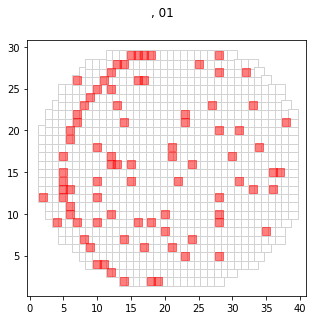

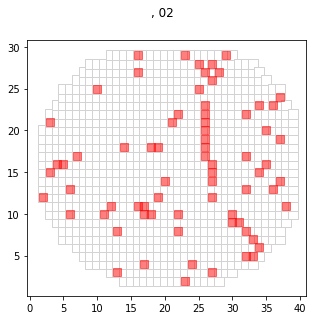

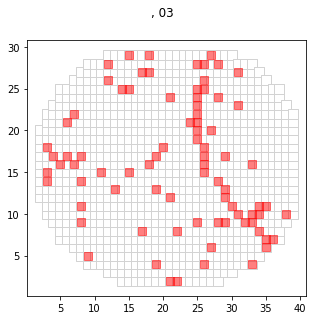

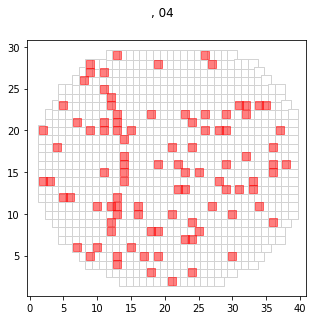

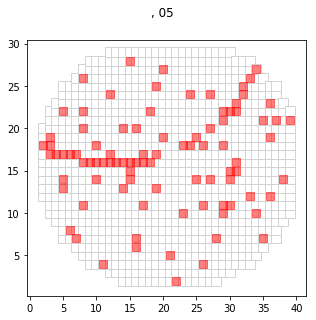

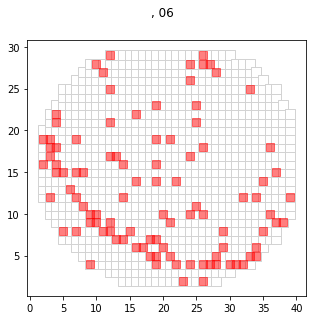

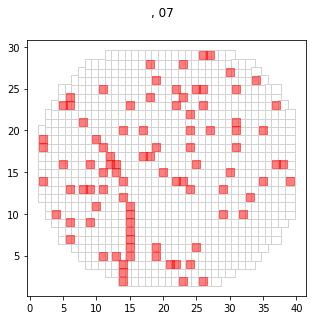

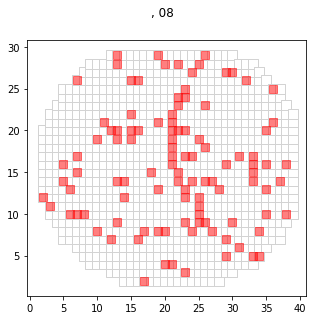

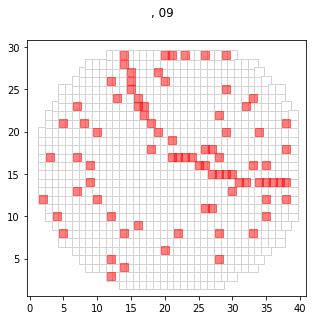

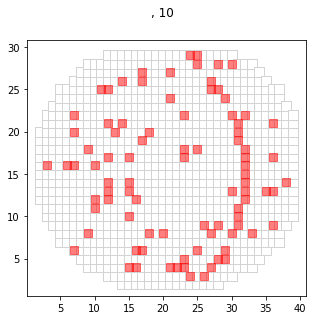

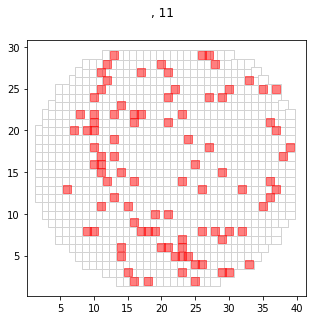

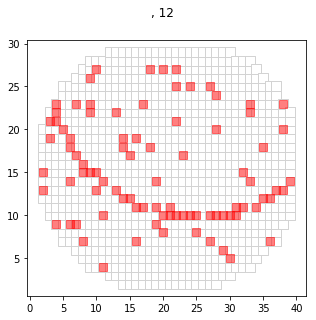

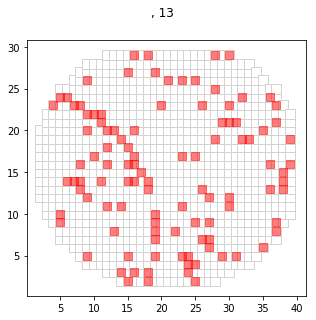

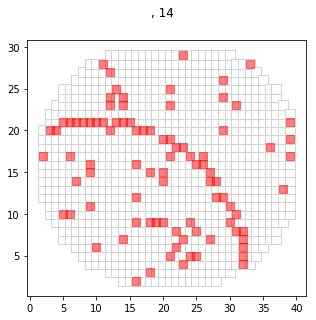

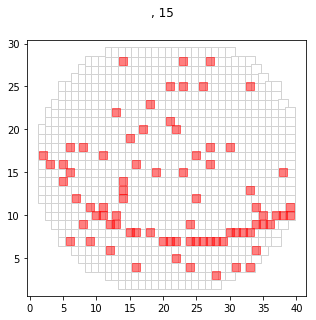

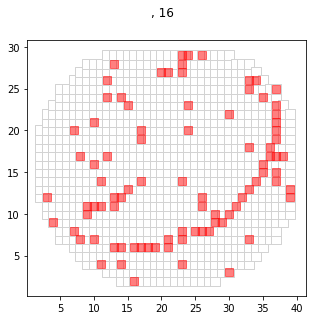

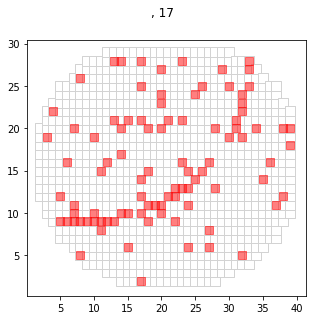

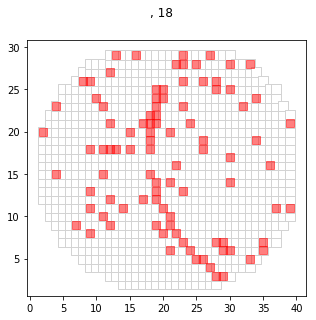

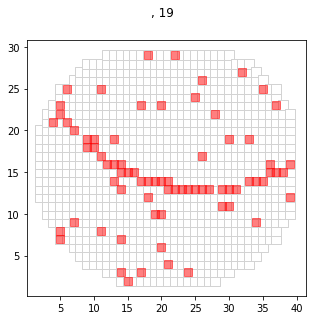

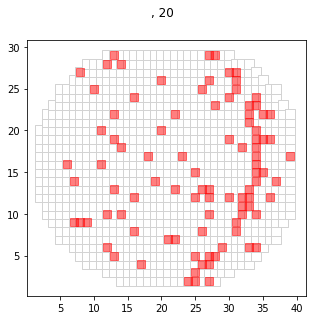

In [6]:
for _ in alot.lotData['unit_id'].unique()[:20]:
    alot.unitplot(columns=['xcoord', 'ycoord'],
                  lot_id='', unit_id=_,
                  val='val', figsize=(5, 4.7),
                  pattern=['B'], m=['s'], s=[50], c=['red'],
                  a=[.5], shown=True)

In [7]:
alot.lotData.groupby(['unit_id'])['val'].value_counts(normalize=True).loc[:, 'G']

unit_id
01    0.905182
02    0.920617
03    0.909592
04    0.893054
05    0.899669
06    0.890849
07    0.898567
08    0.883131
09    0.909592
10    0.901874
11    0.896362
12    0.902977
13    0.883131
14    0.900772
15    0.912900
16    0.902977
17    0.897464
18    0.896362
19    0.917310
20    0.896362
21    0.895259
22    0.905182
23    0.906284
24    0.901874
25    0.894157
26    0.909592
27    0.901874
28    0.897464
29    0.907387
30    0.897464
Name: val, dtype: float64

In [8]:
plt.close('all')

### Extracting

lower Y, higher the denoise weight.  
y=.90 -> weight=.5  
y=.87 -> weight=.7

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

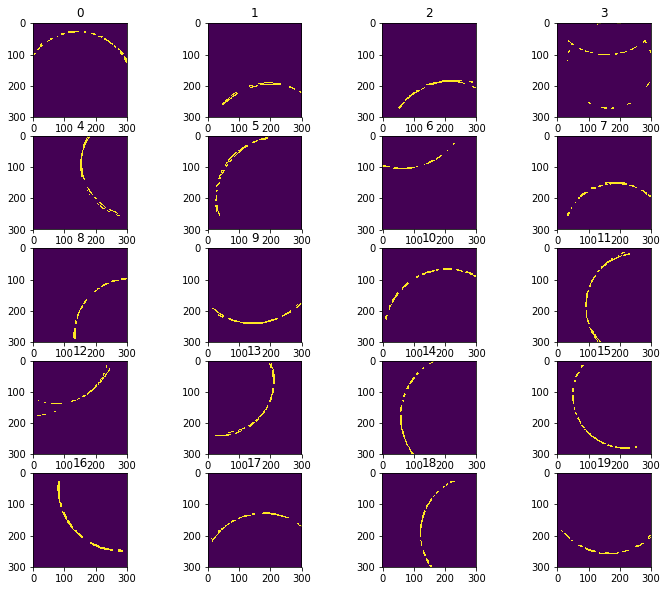

In [9]:
wf_gen = (wfData[1] for wfData in alot.lotData.groupby('unit_id'))
pattern_list = [wafer_pattern_selector(wafer, weight=.5) for wafer in wf_gen]

fig, axes = plt.subplots(5, 4, figsize=(12, 10))
ax = axes.ravel()

for _ in range(20):
    ax[_].imshow(pattern_list[_])
    ax[_].set_title(str(_))

## Flipping

In [10]:
def flipper(marked, axis=None):

    flip_axis = {'vertical': lambda x: x[:,::-1],
                 'horizontal': lambda x: x[::-1,:],
                 'transposed': lambda x: x[::-1,::-1]}

    if axis in flip_axis.keys():
        flipped = flip_axis[axis](marked)

    elif axis not in flip_axis.keys():
        raise Exception('The given axis is inappropriate.')

    return flipped

## Rotating

In [11]:
def mark_rotator(marked, angle):
    rotated = sp.misc.imrotate(marked, angle, interp='nearest')
    #threshold = filters.threshold_minimum(rotated)
    #thresholded = np.where(rotated > threshold, 255, 0)
    return rotated

## Stamping

### Stamp Base

In [12]:
# Create a wafer
wlot = arc_wafer(fac_id='Factory1', lot_cd='ABC', end_tm='20161101123456',
             size=(40, 30), unit_cnt=100, f_type='none', y_val=.95)

-------------------
 LOT_ID : ABCI132
 WF_CNT : 100
-------------------


In [13]:
def sparse_wafer(waferData):
    # % Marking & Typing

    data = waferData
    data.columns
    data['mark'] = np.where(data['val'] == 'B', 255, 0)
    data['xcoord'] = data['xcoord'].astype(int)
    data['ycoord'] = data['ycoord'].astype(int)

    # % Converting Data to a Sparse Matrix
    mat = sp.sparse.csr_matrix((data['mark'], (data['xcoord'], data['ycoord']))).toarray()[2:, 2:]
    mat.shape
    #plt.imshow(mat)

    return mat

In [14]:
def wafer_reformer(waferData, square_shape = reformed_size, threshold_ok = True):
    # % Marking & Typing

    data = waferData
    data.columns
    data['mark'] = np.where(data['val'] == 'B', 255, 0)
    data['xcoord'] = data['xcoord'].astype(int)
    data['ycoord'] = data['ycoord'].astype(int)

    # % Converting Data to a Sparse Matrix
    mat = sp.sparse.csr_matrix((data['mark'], (data['xcoord'], data['ycoord']))).toarray()[2:, 2:]
    #plt.imshow(mat)

    # % Resizing
    resized = sp.misc.imresize(mat, size=square_shape, interp='lanczos')  # nearest : binary | lanczos
    #plt.imshow(resized)

    # % Denoising
    #denoised = cv2.fastNlMeansDenoising(resized, None, 40, 11, 21)
    denoised = denoise_tv_chambolle(resized, weight=0.5, multichannel=True)
    #plt.imshow(denoised)

    res = denoised

    # % Thresholding
    if threshold_ok:
        #local_thresholded = filters.threshold_local(denoised, block_size=21, method='gaussian', mode='reflect')
        #threshold = filters.threshold_mean(thresholded)
        threshold = filters.threshold_minimum(denoised)
        thresholded = np.where(denoised > threshold, 255, 0)
        #plt.imshow(thresholded)

        res = thresholded

    return res

In [15]:
def mark_stamper(sparsed_wafer, marked):
    stamped = np.where(sparsed_wafer + marked >= 255, 255, 0)
    return stamped

### Stamping in Normal

In [16]:
def flip_and_rotator(marked, axis=None, angle=0):

    flip_axis = {'vertical': lambda x: x[:,::-1],
                 'horizontal': lambda x: x[::-1,:],
                 'transposed': lambda x: x[::-1,::-1]}

    if axis in flip_axis.keys():
        flipped = flip_axis[axis](marked)

    elif axis not in flip_axis.keys():
        raise Exception('The given axis is inappropriate.')

    rotated = sp.misc.imrotate(flipped, angle, interp='nearest')
    #threshold = filters.threshold_minimum(rotated)
    #thresholded = np.where(rotated > threshold, 255, 0)

    return rotated

In [17]:
wfdata_gen = it.islice((wfdata[1] for wfdata in wlot.lotData.groupby('unit_id')), 5)
canvas_gen = (wafer_reformer(wfdata) for wfdata in wfdata_gen)  # sparse_wafer -> wafer_reformer
mark_list = pattern_list  # shrinked_list -> pattern_list
axis_list = ['vertical']
angle_gen = range(0, 90, 30)

stamped_list = [mark_stamper(canvas, flip_and_rotator(mark, axis=axis, angle=angle)) for canvas, mark, axis, angle in it.product(canvas_gen, mark_list, axis_list, angle_gen)]
print('Augmentated Pattern : %s' % len(stamped_list))

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Augmentated Pattern : 450


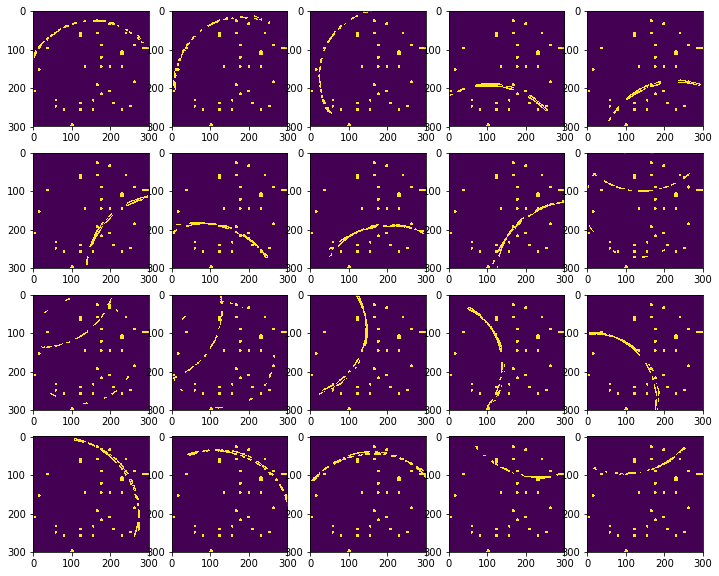

In [18]:
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for ax, sample in zip(axes, stamped_list):
    ax.imshow(sample)

# The Final One : Square Rotation

If the thresholding is wasted?  
Four Types : (Smoothed, Thresholded) * (Pure, Canvas)

## The Raw

Augmentated Pattern : 1080


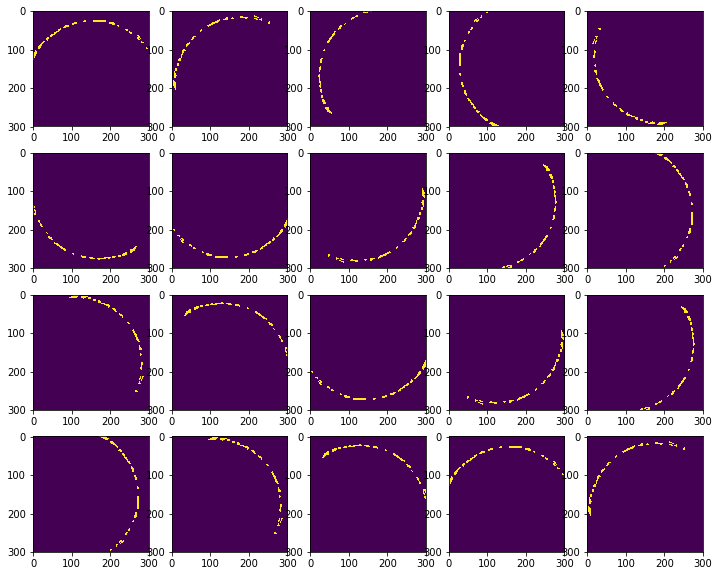

In [19]:
mark_list = pattern_list  # shrinked_list -> pattern_list
axis_list = ['vertical', 'horizontal', 'transposed']
angle_gen = range(0, 360, 30)

raw_list = [flip_and_rotator(mark, axis=axis, angle=angle) for mark, axis, angle in it.product(mark_list, axis_list, angle_gen)]

# The results
print('Augmentated Pattern : %s' % len(raw_list))

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for ax, sample in zip(axes, raw_list):
    ax.imshow(sample)

## The Smoothed

## The Thresholded

In [20]:
# Create a wafer
wlot = arc_wafer(fac_id='Factory1', lot_cd='ABC', end_tm='20161101123456',
             size=(40, 30), unit_cnt=100, f_type='none', y_val=.97)  # THe thresholded pattern would clear

-------------------
 LOT_ID : ABCC243
 WF_CNT : 100
-------------------


-------------------
 LOT_ID : ABCH483
 WF_CNT : 100
-------------------


/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Augmentated Pattern : 5400


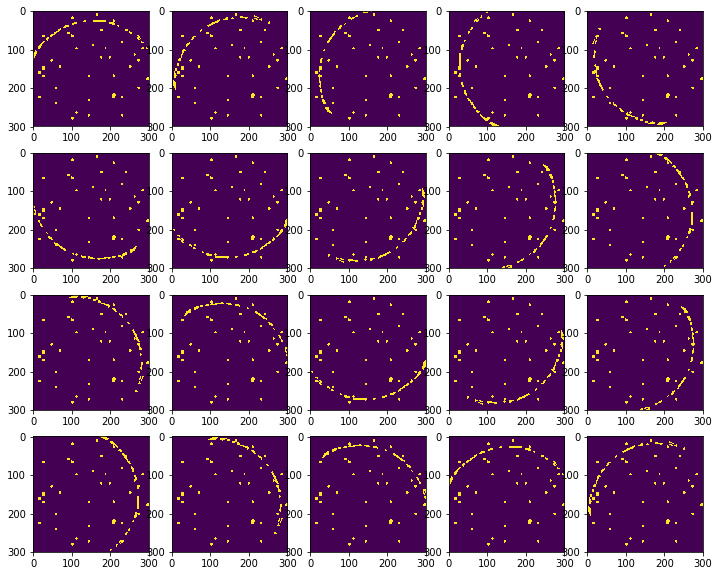

In [21]:
wlot_len = 100
create_len = 5  # Limited Length for memory usage

# Create a wafer
wlot = arc_wafer(fac_id='Factory1', lot_cd='ABC', end_tm='20161101123456',
             size=(40, 30), unit_cnt=wlot_len, f_type='none', y_val=.97)  # THe thresholded pattern would clear

wfdata_gen = it.islice((wfdata[1] for wfdata in wlot.lotData.groupby('unit_id')), create_len)
canvas_gen = (wafer_reformer(wfdata) for wfdata in wfdata_gen)  # sparse_wafer -> wafer_reformer
mark_list = pattern_list  # shrinked_list -> pattern_list
axis_list = ['vertical', 'horizontal', 'transposed']
angle_gen = range(0, 360, 30)

stamped_thresholded_list = tuple(mark_stamper(canvas, flip_and_rotator(mark, axis=axis, angle=angle)) for canvas, mark, axis, angle in it.product(canvas_gen, mark_list, axis_list, angle_gen))

# The results
print('Augmentated Pattern : %s' % len(stamped_thresholded_list))

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for ax, sample in zip(axes, stamped_thresholded_list[:21]):
    ax.imshow(sample)

## Drew on Canvas

In [22]:
zlot = arc_wafer(fac_id='Factory1', lot_cd='ABC', end_tm='20161101123456',
         size=(40, 30), unit_cnt=1, f_type='none', y_val=.0, print_ok=False)

# sparse_wafer, square_transformer -> wafer_reformer
canvas_wafer = wafer_reformer(zlot.lotData)

In [23]:
def pattern_drawer(squared_wafer, color_reverse_ok=True):

    pattern = squared_wafer
    #result = pattern + canvas
    result = np.where(pattern >= 255, 255, pattern)

    if color_reverse_ok:
        result = np.where(result == 255, 0, 255)

    return result

In [24]:
def wafer_drawer(canvas_wafer, squared_wafer, color_reverse_ok=True):

    pattern = squared_wafer
    canvas = np.where(canvas_wafer != 0, 30, 0)
    #result = pattern + canvas
    result = np.where(pattern + canvas >= 255, 255, pattern + canvas)

    if color_reverse_ok:
        result = np.where(result == 255, 0, np.where(result == 30, 220, 255))

    return result

### White Based

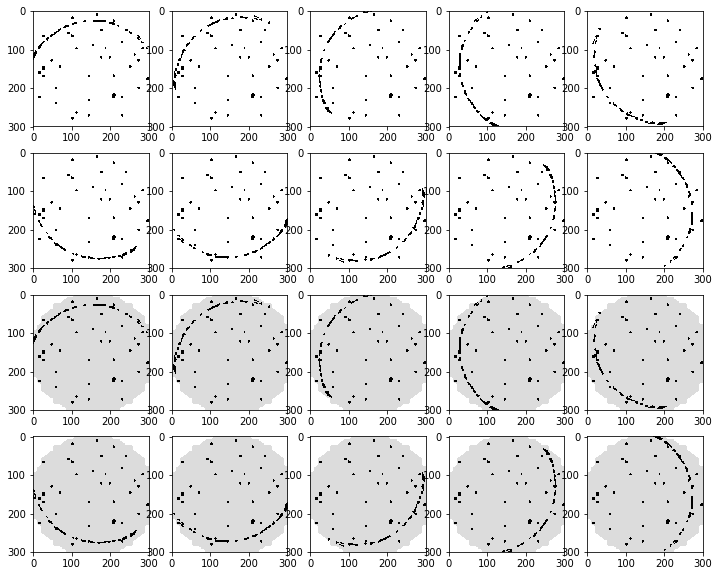

In [25]:
stamped_list = stamped_thresholded_list

pattern_stamper_sample_list = [pattern_drawer(sample) for sample in stamped_list[:10]]
wafer_stamper_sample_list = [wafer_drawer(canvas_wafer, sample) for sample in stamped_list[:10]]
stamper_sample_list = pattern_stamper_sample_list + wafer_stamper_sample_list

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for ax, sample in zip(axes, stamper_sample_list):
    ax.imshow(sample, cmap='gray')

### Black Based

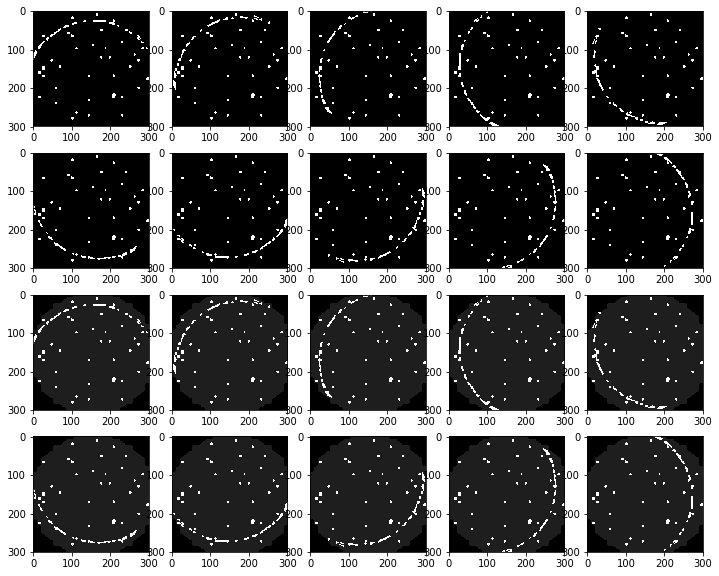

In [26]:
stamped_list = stamped_thresholded_list

pattern_stamper_sample_list = [pattern_drawer(sample, color_reverse_ok=False) for sample in stamped_list[:10]]
wafer_stamper_sample_list = [wafer_drawer(canvas_wafer, sample, color_reverse_ok=False) for sample in stamped_list[:10]]
stamper_sample_list = pattern_stamper_sample_list + wafer_stamper_sample_list

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.ravel()
for ax, sample in zip(axes, stamper_sample_list):
    ax.imshow(sample, cmap='gray')

# Save the results

## Augmentation

In [27]:
wlot_len = 100
create_len = 100

wfdata_gen = it.islice((wfdata[1] for wfdata in wlot.lotData.groupby('unit_id')), create_len)

reformed_list = [wafer_reformer(wfdata) for wfdata in wfdata_gen]  # sparse_wafer -> wafer_reformer
mark_list = pattern_list  # shrinked_list -> pattern_list
axis_list = ['vertical', 'horizontal', 'transposed']
angle_gen = range(0, 360, 30)

#stamped_thresholded_gen = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
#                           for reformed, mark, axis, angle\
#                           in it.product(reformed_list, mark_list, axis_list, angle_gen))
length = create_len * len(mark_list) * len(axis_list) * len(list(angle_gen))

# The results
print('Augmentated Pattern : %s' % length)

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Augmentated Pattern : 108000


## Pattern Only

### White Based

In [28]:
dirname.split('/')[-1]

'bad_base'

Data Count : 108000
wafer_data/bad_image/augmented_reformed_pure/augmented_reformed_pure_000000.png


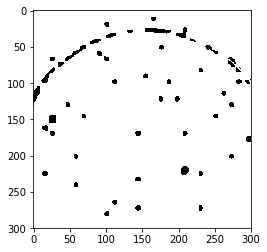

In [29]:
stamped_list = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen))

dirname = 'wafer_data/bad_image/augmented_reformed_pure'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     pattern_drawer(patt))\
      for num, patt in enumerate(stamped_list))

created = sorted(glob(dirname + '/' + '*.png'))
patt_image_name = created[0]
print('Data Count : %s' % len(created))
print(patt_image_name)
plt.imshow(sp.misc.imread(patt_image_name), cmap='gray')

### Black Based

Data Count : 108000
wafer_data/bad_image/augmented_reformed_pure_black/augmented_reformed_pure_black_000000.png


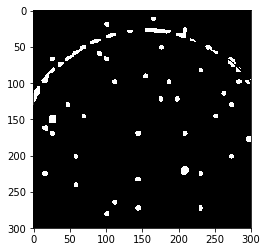

In [30]:
stamped_list = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen))

dirname = 'wafer_data/bad_image/augmented_reformed_pure_black'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     pattern_drawer(patt, color_reverse_ok=False))\
      for num, patt in enumerate(stamped_list))

created = sorted(glob(dirname + '/' + '*.png'))
patt_image_name = created[0]
print('Data Count : %s' % len(created))
print(patt_image_name)
plt.imshow(sp.misc.imread(patt_image_name), cmap='gray')

## Pattern on Canvas

### White Based

Data Count : 108000
wafer_data/bad_image/augmented_reformed_with_canvas/augmented_reformed_with_canvas_000000.png


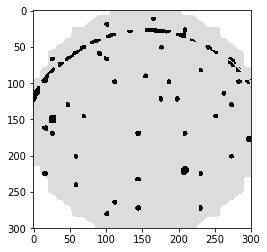

In [31]:
stamped_list = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen))

dirname = 'wafer_data/bad_image/augmented_reformed_with_canvas'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     wafer_drawer(canvas_wafer, patt))\
      for num, patt in enumerate(stamped_list))

created = sorted(glob(dirname + '/' + '*.png'))
canvas_image_name = created[0]
print('Data Count : %s' % len(created))
print(canvas_image_name)
plt.imshow(sp.misc.imread(canvas_image_name), cmap='gray')

### Black Based

Data Count : 108000
wafer_data/bad_image/augmented_reformed_with_canvas_black/augmented_reformed_with_canvas_black_000000.png


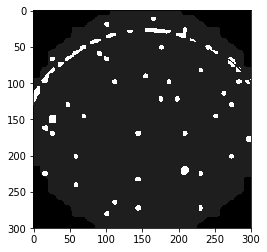

In [33]:
stamped_list = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen))

dirname = 'wafer_data/bad_image/augmented_reformed_with_canvas_black'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     wafer_drawer(canvas_wafer, patt, color_reverse_ok=False))\
      for num, patt in enumerate(stamped_list))

created = sorted(glob(dirname + '/' + '*.png'))
canvas_image_name = created[0]
print('Data Count : %s' % len(created))
print(canvas_image_name)
plt.imshow(sp.misc.imread(canvas_image_name), cmap='gray')

# Preparation : Good Wafer

## Load the Good

In [35]:
dirname = 'wafer_data/good_base'
with open(dirname + '/' + 'good_wafer_y90_base.dump', 'rb') as bak:
    glot = pickle.load(bak)

In [38]:
wfdata_gen = (wfdata[1] for wfdata in glot.lotData.groupby('unit_id'))

# sparse_wafer, square_transformer -> wafer_reformer
mark_gen = [wafer_reformer(wfdata) for wfdata in wfdata_gen]
axis_list = ['vertical', 'horizontal', 'transposed']
angle_gen = range(0, 360, 15)

length = glot.lotData['unit_id'].nunique() * len(axis_list) * len(list(angle_gen))
print('Augmentated Pattern : %s' % length)

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Augmentated Pattern : 72000


## Pattern Only : Good

### White Based

Data Count : 72000
wafer_data/good_image/good_reformed_pure/good_reformed_pure_000000.png


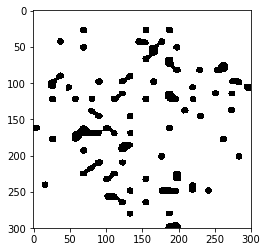

In [39]:
good_list = (flip_and_rotator(mark, axis=axis, angle=angle)\
             for mark, axis, angle in it.product(mark_gen, axis_list, angle_gen))

dirname = 'wafer_data/good_image/good_reformed_pure'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     pattern_drawer(patt))\
      for num, patt in enumerate(good_list))

created = sorted(glob(dirname + '/' + '*.png'))
patt_image_name = created[0]
print('Data Count : %s' % len(created))
print(patt_image_name)
plt.imshow(sp.misc.imread(patt_image_name), cmap='gray')

### Black Based

Data Count : 72000
wafer_data/good_image/good_reformed_pure_black/good_reformed_pure_black_000000.png


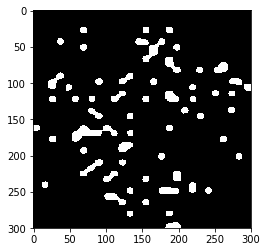

In [40]:
good_list = (flip_and_rotator(mark, axis=axis, angle=angle)\
             for mark, axis, angle in it.product(mark_gen, axis_list, angle_gen))

dirname = 'wafer_data/good_image/good_reformed_pure_black'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     pattern_drawer(patt, color_reverse_ok=False))\
      for num, patt in enumerate(good_list))

created = sorted(glob(dirname + '/' + '*.png'))
patt_image_name = created[0]
print('Data Count : %s' % len(created))
print(patt_image_name)
plt.imshow(sp.misc.imread(patt_image_name), cmap='gray')

## Pattern on Canvas : Good

### Create a Canvas

In [41]:
zlot = arc_wafer(fac_id='Factory1', lot_cd='ABC', end_tm='20161101123456',
         size=(40, 30), unit_cnt=1, f_type='none', y_val=.0, print_ok=False)

canvas_wafer = wafer_reformer(zlot.lotData)

### White Based

Data Count : 72000
wafer_data/good_image/good_reformed_with_canvas/good_reformed_with_canvas_000000.png


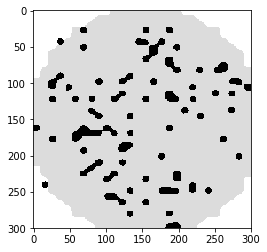

In [42]:
good_list = (flip_and_rotator(mark, axis=axis, angle=angle)\
             for mark, axis, angle in it.product(mark_gen, axis_list, angle_gen))

dirname = 'wafer_data/good_image/good_reformed_with_canvas'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     wafer_drawer(canvas_wafer, patt))\
      for num, patt in enumerate(good_list))

created = sorted(glob(dirname + '/' + '*.png'))
good_image_name = created[0]
print('Data Count : %s' % len(created))
print(good_image_name)
plt.imshow(sp.misc.imread(good_image_name), cmap='gray')

### Black Based

Data Count : 72000
wafer_data/good_image/good_reformed_with_canvas_black/good_reformed_with_canvas_black_000000.png


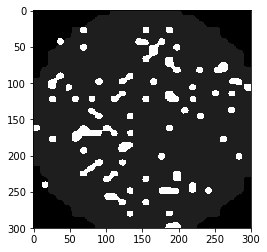

In [43]:
good_list = (flip_and_rotator(mark, axis=axis, angle=angle)\
             for mark, axis, angle in it.product(mark_gen, axis_list, angle_gen))

dirname = 'wafer_data/good_image/good_reformed_with_canvas_black'
imglabel = dirname.split('/')[-1]
os.makedirs(dirname, exist_ok=True)
tuple(sp.misc.imsave(dirname + '/' + imglabel + '_' + str(num).zfill(6) + '.png',
                     wafer_drawer(canvas_wafer, patt, color_reverse_ok=False))\
      for num, patt in enumerate(good_list))

created = sorted(glob(dirname + '/' + '*.png'))
good_image_name = created[0]
print('Data Count : %s' % len(created))
print(good_image_name)
plt.imshow(sp.misc.imread(good_image_name), cmap='gray')

# Dump the Bad as ARRAY (Black)

In [63]:
def mark_shrinker_otsu(marked):

    shrinked = sp.misc.imresize(marked, size=(40-2, 30-2), interp='nearest')
    point_thres = filters.threshold_otsu(shrinked)
    pointed = np.where(shrinked > point_thres, 255, 0)

    return pointed

In [45]:
stamped_list = it.islice((mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen)), 2)

stamped_list = list(stamped_list)

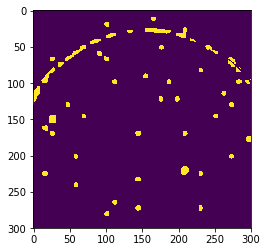

In [49]:
plt.imshow(stamped_list[0])

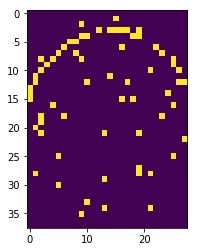

In [52]:
plt.imshow(mark_shrinker_minimum(stamped_list[0]))

In [64]:
stamped_list = (mark_stamper(reformed, flip_and_rotator(mark, axis=axis, angle=angle))\
                for reformed, mark, axis, angle\
                in it.product(reformed_list, mark_list, axis_list, angle_gen))

stamped_array = np.stack(mark_shrinker_otsu(item)\
                        for item\
                        in stamped_list)

In [65]:
dirname = 'wafer_data/bad_image'
os.makedirs(dirname, exist_ok=True)
with open(dirname + '/' + 'augmented_reformed_y90_array.dump', 'wb') as bak:
    pickle.dump(stamped_array, bak)

Done.